# Homework 2: Image Classification with Xception (keras)
In this assignment you will scrape data from google image search on swiss politicians for the last 10 years. 

You will build from scratch a Xception CNN model (state of the art image classification model) to classify the party based on its politicians photographs. 

You will apply what you've learned at class 8 and lab 9. You need to read the Xception paper (https://arxiv.org/pdf/1610.02357.pdf) and re use a slightly modified version of this code (https://towardsdatascience.com/xception-from-scratch-using-tensorflow-even-better-than-inception-940fb231ced9 )

In [1]:
import os
import requests
from io import BytesIO
from PIL import Image
from bs4 import BeautifulSoup
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
politicians = {
    'SP': ['Christian Levrat', 'Simonetta Sommaruga', 'Alain Berset'],
    'SVP': ['Ueli Maurer', 'Christoph Blocher', 'Guy Parmelin'],
    'FDP': ['Ignazio Cassis', 'Johann Schneider-Ammann', 'Didier Burkhalter'],
    'CVP': ['Doris Leuthard', 'Viola Amherd', 'Gerhard Pfister'],
    'GLP': ['Martin Bäumle', 'Tiana Angelina Moser', 'Jürg Grossen']
}
k=0
for party, politicians_list in politicians.items():
    k=0
    os.makedirs('data', exist_ok=True)
    for i, politician in enumerate(politicians_list):
        query = f"{politician} {party} schweiz"
        url = f"https://www.google.com/search?q={query}&tbm=isch"
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        img_tags = soup.find_all("img")
        
        for j, img_tag in enumerate(img_tags):
            image_url = img_tag["src"]
            if "http" not in image_url:
                continue
            try:
                img_data = requests.get(image_url).content
                img = Image.open(BytesIO(img_data))
                img = img.convert("RGB")
                img.save(f"data/{party}_{k}.jpg")
                #print(f"Saved image {k} for {politician} from {party} party")
                k+=1
            except OSError:
                img = img.convert("RGB")
                img.save(f"data/{party}_{k}.jpg")
                #print(f"Saved image {k} for {politician} from {party} party (converted RGBA to RGB)")
                k+=1


Question 1 (15 Points)

a) Create a keras dataset object (image_dataset_from_directory) for training, testing and validating dataset. 

b) Check the basic statistics for image dimension and choose a input size accordingly (this will be contrained by the model you choose. In this lab, the architecture of the model is pre defined by its author.)

In [3]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
parties = ["CVP", "FDP", "GLP", "SP", "SVP"]
original_dir = pathlib.Path("data")
new_base_dir = pathlib.Path("party_classification")

def make_subset(subset_name, start_index, end_index):
    for category in parties:
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}_{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=30)
make_subset("validation", start_index=30, end_index=45)
make_subset("test", start_index=45, end_index=60)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(299, 299),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(299, 299),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(299, 299),
    batch_size=32)

Found 150 files belonging to 5 classes.
Found 75 files belonging to 5 classes.
Found 75 files belonging to 5 classes.


Question 2 and 3 (30 Points)

a) Add data augmentation step to your code

b) Explain why you choose those transformation from the available ones

Answer b):



In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Question 4 (15 Points)

Code explicitly (layer by layer) a mini Xception neural network 

In [5]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 5, activation = 'softmax')(x)
    
    return x
# model code

input = Input(shape = (299,299,3))
x=data_augmentation(input) #added here the data augmentation
x = entry_flow(x)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)


Question 5 (15 Points)

a) Print the model summary in table and graph format. 

b) When saving the checkpoint of the model after training in a .keras file (or .h5) file, we say we are 'saving the model'. What does that means? How many parameters are we saving in that file for this type of NN?

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  864         ['sequential[0][0]']             
                                )                                                                 
                                                                                              

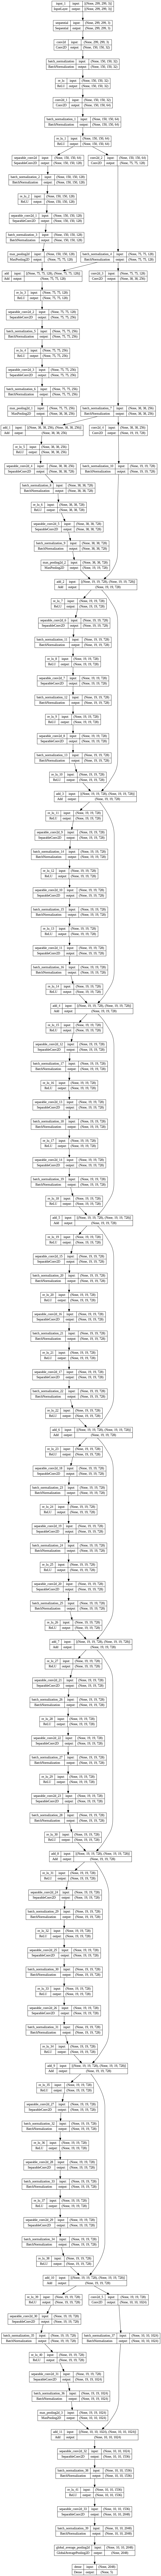

In [7]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset)

Epoch 1/5
5/5 [==============================] - 350s 67s/step - loss: 1.6544 - accuracy: 0.2733 - val_loss: 1.6095 - val_accuracy: 0.1200
Epoch 2/5
5/5 [==============================] - 346s 68s/step - loss: 1.5129 - accuracy: 0.3400 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 3/5
5/5 [==============================] - 326s 66s/step - loss: 1.4546 - accuracy: 0.3933 - val_loss: 1.6095 - val_accuracy: 0.1467
Epoch 4/5
5/5 [==============================] - 329s 67s/step - loss: 1.4248 - accuracy: 0.3600 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 5/5
5/5 [==============================] - 323s 65s/step - loss: 1.3627 - accuracy: 0.4200 - val_loss: 1.6096 - val_accuracy: 0.1867


Question 6 (15 Points)

Plot Training and validation accuracy in one plot, with different color or patterns for each stream of values

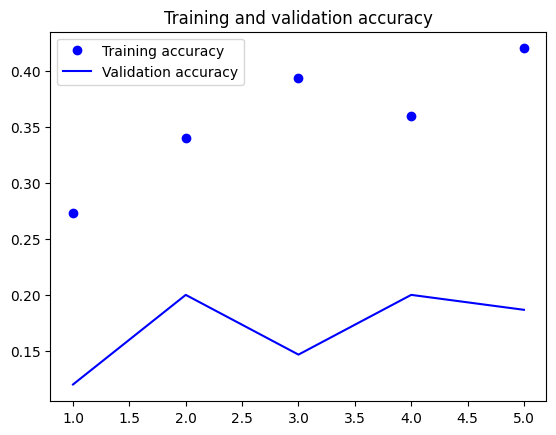

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.show()

Question 7 (15 Points)

Based on the reading of the paper and class 8 slides: 

a) Does the Xception NN has residual connections? What are those and which problem within deep learning do they try to solve?

b) what are residual Depthwise Seperable Convolutions? 

Deliver

In [10]:
#HOW TO DELIVER: https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab
#download this notebook after all your answers and upload it to the files tab on the left
#right click on it to check the path 
#replace the path ('/content/Untitled0.ipynb') by your file path
%%shell
jupyter nbconvert --to html /content/Untitled0.ipynb

#refresh the folder (not the page)
#download the html
     

[NbConvertApp] WARNING | pattern '/content/Untitled0.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec

CalledProcessError: ignored